# 수입 우범화물 선별
## XGBoost (max_depth: 3)

#### AI 경진대회
- 주관: 관세청, 충남대학교
- 주제 : AI를 활용하여 우리나라로 수입되는 화물의 우범도를 예측하는 모델 개발
#### 배경 및 목적 :
- 관세청은 우리나라로 들어오거나 나가는 모든 물품을 신속하게 통관하는 한편, 관련 법규를 엄정하게 진행함으로써 튼튼한 경제, 안전한 사회를 위해 관세국경을 수호화는 기관임
- 매년 약 1천백만건, 매달 약 1백만건이 수입신고되는 상황에서 수입 화물을 검사할 수 있는 인력은 한정되어 있다 보니, 관세국경단계에서 사회안전, 국민건강 등을 위협하는 고위험물품을 선별(타겟팅) 하여 선제적으로 차단하는 기능이 필요함
- 검사 기준 수립에 다양한 선별 기법이 활용되고 있는 가운데, 요즘 가장 핫한 AI를 활용하여 수입화물의 우범도를 예측하는 모델의 개발이 필요함

# 1. 분석 환경 설정 및 데이터 로딩<a id='id1'></a> 

In [1]:
# 모델 구현 시간 체크
import time
# 시작시간 체크
start = time.time()

In [2]:
# 패키지 로딩
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 화면 디스플레이 전체 구간을 넓게
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 999) # pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 999) # pd.options.display.max_columns = 999
pd.set_option('display.width', 1000)

# 한글폰트 적용
plt.rcParams['font.family'] = 'Malgun Gothic' #맑은 고딕

In [3]:
# 수입 데이터 로딩 (가상데이터)
df_org = pd.read_csv('train.csv')

# 2. 데이터 전처리 <a id='id2'></a>

## 2.1. 전처리 기본(수치형 변수 및 범주형 변수 지정 등)

In [4]:
# 데이터 사이즈 확인
# 행 갯수: 76837, 열 갯수: 24
df_org.shape

(76837, 24)

In [5]:
# 데이터 샘플 3개 확인(램덤으로 뽑아서 확인)
df_org.sample(3)

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,검사결과코드,우범여부,핵심적발
42098,12453695,2020-05-22,40,7QFMD,WFB5XMC,GSSG2U6,PR5UFJ,C,B,11,21,11,3360.3,4.609557e+05,10,2006003,6810191000,TR,TR,A,8.0,M3,1,1
39685,89005964,2020-05-13,40,2O5A2,CHRCGFJ,6F9DTNX,PR5UFJ,D,B,11,21,11,189.3,4.335933e+02,40,2002079,6307909000,CN,CN,FCN1,4.0,A,0,0
53342,97302633,2020-07-03,40,HJXRX,SMH7DL3,NaN,NaN,D,B,11,21,11,7709.4,1.674457e+06,40,4077004,2103909090,CN,CN,FCN1,44.5,A,0,0


In [6]:
df_org.head(5)
# NaN : 비어있는 부분이 있음!! (미싱벨류)

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,검사결과코드,우범여부,핵심적발
0,57298928,2020-01-01,121,2O5A2,82ZHWNL,NaN,TQ18AK,D,B,15,23,43,126.0,5.397966e+03,10,2106003,8481900000,US,US,A,8.0,N3,1,1
1,85092852,2020-01-01,30,305K5,5IS70LE,NaN,NaN,C,B,11,21,11,29845.4,5.730972e+05,40,4077010,2106909099,US,US,A,8.0,A,0,0
2,63014158,2020-01-01,20,CGMT6,GJ5KBL3,R9ZQOG7,NaN,D,B,11,21,18,23557.5,5.219489e+04,40,4077007,6307909000,US,US,A,10.0,A,0,0
3,40175917,2020-01-01,40,QWUTG,PBYW02T,NaN,NaN,C,B,94,21,43,12450.1,1.773608e+06,40,4077106,6505009090,CN,CN,A,8.0,A,0,0
4,11602631,2020-01-01,30,0X1CO,MCX0GJB,4Z9PX0Y,NaN,C,B,11,21,43,15692.7,8.777327e+06,40,2006075,6204320000,CN,CN,FCN1,5.2,M1_N1,1,1


In [7]:
df_org.tail(5)

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,검사결과코드,우범여부,핵심적발
76832,94508764,2020-09-30,40,3A8I7,BECE6R3,FYZA0QQ,NaN,C,D,11,21,11,5386.6,1.246923e+05,10,4077003,8703241020,AE,AE,C,8.0,A,0,0
76833,17853106,2020-09-30,40,QK03W,2WEWINH,QUM8VZX,NaN,B,B,91,21,11,7536.0,1.178062e+06,10,1612033,9209999000,JP,JP,A,8.0,A_N5_D6,1,1
76834,26558010,2020-09-30,40,S86Q6,GIWBVU7,PHNRCZY,NaN,D,B,91,21,11,2657.8,2.018556e+07,40,4002001,3203001990,CN,CN,FCN1,0.0,A_K,0,0
76835,48138979,2020-09-30,40,OGZCI,N3UTDBA,8DJ0WHZ,ID7FLR,D,B,87,21,14,3753.6,6.541088e+06,50,6277033,1513199000,US,US,A,3.0,F2,1,2
76836,81391181,2020-09-30,40,CGMT6,LIPZTZ4,ZLF7Q7N,QJ0YGH,D,B,15,21,18,5680.3,1.314910e+05,40,2010033,8703241020,AE,AE,C,8.0,N3,1,1


In [8]:
df_org['우범여부'].value_counts()
# 0 : 정상 데이터
# 1 : 문제가 있는 데이터(우범)

0    59265
1    17572
Name: 우범여부, dtype: int64

In [9]:
df_org['핵심적발'].value_counts()
# 우범인 것들 중에도 핵식인 것들에 대해 2와 1로 표현

0    59265
2     9049
1     8523
Name: 핵심적발, dtype: int64

In [10]:
# 불필요한 변수 삭제
# 기본은 우범여뷰를 맞추는 것이므로 아래 2개는 삭제
del df_org['검사결과코드']
del df_org['핵심적발']

In [11]:
df_org.columns #21개 x , 우범여부 y

Index(['신고번호', '신고일자', '통관지세관부호', '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드', '수입신고구분코드', '수입거래구분코드', '수입종류코드', '징수형태코드', '신고중량(KG)', '과세가격원화금액', '운송수단유형코드', '반입보세구역부호', 'HS10단위부호', '적출국가코드', '원산지국가코드', '관세율구분코드', '관세율', '우범여부'], dtype='object')

In [12]:
df_org.shape

(76837, 22)

In [13]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76837 entries, 0 to 76836
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   신고번호      76837 non-null  int64  
 1   신고일자      76837 non-null  object 
 2   통관지세관부호   76837 non-null  int64  
 3   신고인부호     76837 non-null  object 
 4   수입자부호     76829 non-null  object 
 5   해외거래처부호   50544 non-null  object 
 6   특송업체부호    25106 non-null  object 
 7   수입통관계획코드  76837 non-null  object 
 8   수입신고구분코드  76837 non-null  object 
 9   수입거래구분코드  76837 non-null  int64  
 10  수입종류코드    76837 non-null  int64  
 11  징수형태코드    76837 non-null  int64  
 12  신고중량(KG)  76837 non-null  float64
 13  과세가격원화금액  76837 non-null  float64
 14  운송수단유형코드  76837 non-null  int64  
 15  반입보세구역부호  76837 non-null  int64  
 16  HS10단위부호  76837 non-null  int64  
 17  적출국가코드    76837 non-null  object 
 18  원산지국가코드   76837 non-null  object 
 19  관세율구분코드   76837 non-null  object 
 20  관세율       76837 non-null  fl

In [14]:
# 범주형 변수 지정
discrete_columns = ['신고일자',  '통관지세관부호',
       '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드', 
       '수입신고구분코드', '수입거래구분코드',
       '수입종류코드', '징수형태코드', 
       '운송수단유형코드', '반입보세구역부호', 
       'HS10단위부호', '적출국가코드', '원산지국가코드', '관세율구분코드']

# 범주형 변수들을 문자열로 지정 ('object' -> 'string')
for var in discrete_columns:
    df_org[var] = df_org[var].astype(str)

In [15]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76837 entries, 0 to 76836
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   신고번호      76837 non-null  int64  
 1   신고일자      76837 non-null  object 
 2   통관지세관부호   76837 non-null  object 
 3   신고인부호     76837 non-null  object 
 4   수입자부호     76837 non-null  object 
 5   해외거래처부호   76837 non-null  object 
 6   특송업체부호    76837 non-null  object 
 7   수입통관계획코드  76837 non-null  object 
 8   수입신고구분코드  76837 non-null  object 
 9   수입거래구분코드  76837 non-null  object 
 10  수입종류코드    76837 non-null  object 
 11  징수형태코드    76837 non-null  object 
 12  신고중량(KG)  76837 non-null  float64
 13  과세가격원화금액  76837 non-null  float64
 14  운송수단유형코드  76837 non-null  object 
 15  반입보세구역부호  76837 non-null  object 
 16  HS10단위부호  76837 non-null  object 
 17  적출국가코드    76837 non-null  object 
 18  원산지국가코드   76837 non-null  object 
 19  관세율구분코드   76837 non-null  object 
 20  관세율       76837 non-null  fl

In [16]:
# 수치형 변수 지정
numeric_columns = ['신고중량(KG)', '과세가격원화금액', '관세율', '우범여부']

# 수치형 변수를 자연로그로 변환
# 로그로 취하면 스케일이 줄어드는 효과가 있음
for var in ['신고중량(KG)', '과세가격원화금액']:
    df_org[var] = df_org[var].apply(lambda x: np.log1p(x))

In [17]:
df_org.head(5)

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,우범여부
0,57298928,2020-01-01,121,2O5A2,82ZHWNL,nan,TQ18AK,D,B,15,23,43,4.844187,8.593963,10,2106003,8481900000,US,US,A,8.0,1
1,85092852,2020-01-01,30,305K5,5IS70LE,nan,nan,C,B,11,21,11,10.303820,13.258812,40,4077010,2106909099,US,US,A,8.0,0
2,63014158,2020-01-01,20,CGMT6,GJ5KBL3,R9ZQOG7,nan,D,B,11,21,18,10.067242,10.862759,40,4077007,6307909000,US,US,A,10.0,0
3,40175917,2020-01-01,40,QWUTG,PBYW02T,nan,nan,C,B,94,21,43,9.429564,14.388527,40,4077106,6505009090,CN,CN,A,8.0,0
4,11602631,2020-01-01,30,0X1CO,MCX0GJB,4Z9PX0Y,nan,C,B,11,21,43,9.661015,15.987683,40,2006075,6204320000,CN,CN,FCN1,5.2,1


## 2.2. 훈련데이터와 테스트데이터 분리 및 범주형 변수 전처리 

In [18]:
# 날짜 순에 따라 90:10 으로 훈련 및 테스트 데이터 분리
df_org_train = df_org.iloc[:int(len(df_org)*0.9), :]
df_org_test = df_org.iloc[int(len(df_org)*0.9):, :]

In [19]:
# 데이터 사이즈 확인
print(df_org_train.shape, df_org_test.shape)

(69153, 22) (7684, 22)


In [20]:
df_org.columns

Index(['신고번호', '신고일자', '통관지세관부호', '신고인부호', '수입자부호', '해외거래처부호', '특송업체부호', '수입통관계획코드', '수입신고구분코드', '수입거래구분코드', '수입종류코드', '징수형태코드', '신고중량(KG)', '과세가격원화금액', '운송수단유형코드', '반입보세구역부호', 'HS10단위부호', '적출국가코드', '원산지국가코드', '관세율구분코드', '관세율', '우범여부'], dtype='object')

In [21]:
df_org.shape

(76837, 22)

In [22]:
# 범주형 변수 전처리 1단계: label encoding --> 각 범주형 변수가 갖는 클래스에 고유의 식별번호 부여
# 예) 수입자 상호: AAABB -> 1, 가나다라 -> 2, ...
# 정보에 손실이 있을 수도 있지만 이게 영향이 미치지 않을 수도 있음
label_encoding_ref = {}
for var in discrete_columns:
    label_encoding_ref[var] = {code: i+1 for i, code in enumerate(df_org_train[var].unique())} # 0 padding for unseen data in test
    #print(label_encoding_ref[var])
    df_org_train[var] = [label_encoding_ref[var][x] for x in df_org_train[var]]
    df_org_test[var] = [label_encoding_ref[var].get(x,0) for x in df_org_test[var]]

df_org_train.reset_index(drop=True, inplace=True)
df_org_test.reset_index(drop=True, inplace=True)

<ipython-input-22-cb344b4330e1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_org_train[var] = [label_encoding_ref[var][x] for x in df_org_train[var]]
<ipython-input-22-cb344b4330e1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_org_test[var] = [label_encoding_ref[var].get(x,0) for x in df_org_test[var]]


In [23]:
# 트레인데이터 샘플 확인
df_org_train.sample(3)

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,우범여부
4322,93093565,14,4,238,1248,1,2,1,1,2,2,2,6.062389,12.379761,1,54,297,18,11,15,5.0,0
6064,20365042,17,4,98,3537,1,12,2,1,2,2,2,10.253024,13.224965,2,17,11,3,5,1,8.0,0
57913,48380411,200,4,52,4937,1,2,2,1,2,2,6,10.114291,15.745779,2,7,93,2,2,1,27.0,0


In [24]:
# 테스트데이터 샘플 확인
df_org_test.sample(3)

,신고번호,신고일자,통관지세관부호,신고인부호,수입자부호,해외거래처부호,특송업체부호,수입통관계획코드,수입신고구분코드,수입거래구분코드,수입종류코드,징수형태코드,신고중량(KG),과세가격원화금액,운송수단유형코드,반입보세구역부호,HS10단위부호,적출국가코드,원산지국가코드,관세율구분코드,관세율,우범여부
5707,98211514,0,2,21,6395,730,2,1,1,21,2,6,9.010291,17.129576,2,100,1304,1,1,1,5.0,0
4353,37400508,0,3,45,2852,2306,2,3,1,2,2,2,8.144040,13.467162,2,116,309,3,38,1,13.0,0
5134,92326794,0,2,692,2506,3242,2,3,1,2,2,2,8.935798,12.048378,2,89,12,8,20,3,6.5,0


In [25]:
# one-hot-encoding
# 예) A,B,C 3개의 클래스가 있는 범주형 변수를 다음과 같이 변환
# A -> [1,0,0] / B -> [0,1,0] / C -> [0,0,1]

# 원핫인코더 로딩
from sklearn.preprocessing import  OneHotEncoder
# 원핫인코더 활성화
xgbohe = OneHotEncoder(categories="auto", handle_unknown='ignore')
# 훈련데이터: 범주형 변수만 분리하여 원핫인코딩 적용
df_org_train_cat = xgbohe.fit_transform(df_org_train[discrete_columns])
df_org_train_cat = pd.DataFrame(df_org_train_cat.toarray(), 
                                columns = xgbohe.get_feature_names(discrete_columns))
# 수치형 변수 분리
df_org_train_num = df_org_train[numeric_columns]

# 원핫인코딩된 범주형 변수와 수치형 변수 재결합
df_org_train = pd.concat([df_org_train_num, df_org_train_cat], axis=1)

In [26]:
# 훈련데이터 샘플 확인
df_org_train.head(1)

,신고중량(KG),과세가격원화금액,관세율,우범여부,신고일자_1,신고일자_2,신고일자_3,신고일자_4,신고일자_5,신고일자_6,신고일자_7,신고일자_8,신고일자_9,신고일자_10,신고일자_11,신고일자_12,신고일자_13,신고일자_14,신고일자_15,신고일자_16,신고일자_17,신고일자_18,신고일자_19,신고일자_20,신고일자_21,신고일자_22,신고일자_23,신고일자_24,신고일자_25,신고일자_26,신고일자_27,신고일자_28,신고일자_29,신고일자_30,신고일자_31,신고일자_32,신고일자_33,신고일자_34,신고일자_35,신고일자_36,신고일자_37,신고일자_38,신고일자_39,신고일자_40,신고일자_41,신고일자_42,신고일자_43,신고일자_44,신고일자_45,신고일자_46,신고일자_47,신고일자_48,신고일자_49,신고일자_50,신고일자_51,신고일자_52,신고일자_53,신고일자_54,신고일자_55,신고일자_56,신고일자_57,신고일자_58,신고일자_59,신고일자_60,신고일자_61,신고일자_62,신고일자_63,신고일자_64,신고일자_65,신고일자_66,신고일자_67,신고일자_68,신고일자_69,신고일자_70,신고일자_71,신고일자_72,신고일자_73,신고일자_74,신고일자_75,신고일자_76,신고일자_77,신고일자_78,신고일자_79,신고일자_80,신고일자_81,신고일자_82,신고일자_83,신고일자_84,신고일자_85,신고일자_86,신고일자_87,신고일자_88,신고일자_89,신고일자_90,신고일자_91,신고일자_92,신고일자_93,신고일자_94,신고일자_95,신고일자_96,신고일자_97,신고일자_98,신고일자_99,신고일자_100,신고일자_101,신고일자_102,신고일자_103,신고일자_104,신고일자_105,신고일자_106,신고일자_107,신고일자_108,신고일자_109,신고일자_110,신고일자_111,신고일자_112,신고일자_113,신고일자_114,신고일자_115,신고일자_116,신고일자_117,신고일자_118,신고일자_119,신고일자_120,신고일자_121,신고일자_122,신고일자_123,신고일자_124,신고일자_125,신고일자_126,신고일자_127,신고일자_128,신고일자_129,신고일자_130,신고일자_131,신고일자_132,신고일자_133,신고일자_134,신고일자_135,신고일자_136,신고일자_137,신고일자_138,신고일자_139,신고일자_140,신고일자_141,신고일자_142,신고일자_143,신고일자_144,신고일자_145,신고일자_146,신고일자_147,신고일자_148,신고일자_149,신고일자_150,신고일자_151,신고일자_152,신고일자_153,신고일자_154,신고일자_155,신고일자_156,신고일자_157,신고일자_158,신고일자_159,신고일자_160,신고일자_161,신고일자_162,신고일자_163,신고일자_164,신고일자_165,신고일자_166,신고일자_167,신고일자_168,신고일자_169,신고일자_170,신고일자_171,신고일자_172,신고일자_173,신고일자_174,신고일자_175,신고일자_176,신고일자_177,신고일자_178,신고일자_179,신고일자_180,신고일자_181,신고일자_182,신고일자_183,신고일자_184,신고일자_185,신고일자_186,신고일자_187,신고일자_188,신고일자_189,신고일자_190,신고일자_191,신고일자_192,신고일자_193,신고일자_194,신고일자_195,신고일자_196,신고일자_197,신고일자_198,신고일자_199,신고일자_200,신고일자_201,신고일자_202,신고일자_203,신고일자_204,신고일자_205,신고일자_206,신고일자_207,신고일자_208,신고일자_209,신고일자_210,신고일자_211,신고일자_212,신고일자_213,신고일자_214,신고일자_215,신고일자_216,신고일자_217,신고일자_218,신고일자_219,신고일자_220,신고일자_221,신고일자_222,신고일자_223,신고일자_224,신고일자_225,신고일자_226,신고일자_227,신고일자_228,신고일자_229,신고일자_230,신고일자_231,신고일자_232,신고일자_233,신고일자_234,신고일자_235,신고일자_236,신고일자_237,신고일자_238,신고일자_239,신고일자_240,신고일자_241,신고일자_242,신고일자_243,통관지세관부호_1,통관지세관부호_2,통관지세관부호_3,통관지세관부호_4,통관지세관부호_5,통관지세관부호_6,통관지세관부호_7,통관지세관부호_8,통관지세관부호_9,통관지세관부호_10,통관지세관부호_11,통관지세관부호_12,통관지세관부호_13,통관지세관부호_14,통관지세관부호_15,통관지세관부호_16,통관지세관부호_17,통관지세관부호_18,통관지세관부호_19,통관지세관부호_20,통관지세관부호_21,통관지세관부호_22,통관지세관부호_23,통관지세관부호_24,통관지세관부호_25,통관지세관부호_26,통관지세관부호_27,통관지세관부호_28,통관지세관부호_29,통관지세관부호_30,통관지세관부호_31,통관지세관부호_32,통관지세관부호_33,통관지세관부호_34,통관지세관부호_35,통관지세관부호_36,통관지세관부호_37,통관지세관부호_38,통관지세관부호_39,통관지세관부호_40,신고인부호_1,신고인부호_2,신고인부호_3,신고인부호_4,신고인부호_5,신고인부호_6,신고인부호_7,신고인부호_8,신고인부호_9,신고인부호_10,신고인부호_11,신고인부호_12,신고인부호_13,신고인부호_14,신고인부호_15,신고인부호_16,신고인부호_17,신고인부호_18,신고인부호_19,신고인부호_20,신고인부호_21,신고인부호_22,신고인부호_23,신고인부호_24,신고인부호_25,신고인부호_26,신고인부호_27,신고인부호_28,신고인부호_29,신고인부호_30,신고인부호_31,신고인부호_32,신고인부호_33,신고인부호_34,신고인부호_35,신고인부호_36,신고인부호_37,신고인부호_38,신고인부호_39,신고인부호_40,신고인부호_41,신고인부호_42,신고인부호_43,신고인부호_44,신고인부호_45,신고인부호_46,신고인부호_47,신고인부호_48,신고인부호_49,신고인부호_50,신고인부호_51,신고인부호_52,신고인부호_53,신고인부호_54,신고인부호_55,신고인부호_56,신고인부호_57,신고인부호_58,신고인부호_59,신고인부호_60,신고인부호_61,신고인부호_62,신고인부호_63,신고인부호_64,신고인부호_65,신고인부호_66,신고인부호_67,신고인부호_68,신고인부호_69,신고인부호_70,신고인부호_71,신고인부호_72,신고인부호_73,신고인부호_74,신고인부호_75,신고인부호_76,신고인부호_77,신고인부호_78,신고인부호_79,신고인부호_80,신고인부호_81,신고인부호_82,신고인부호_83,신고인부호_84,신고인부호_85,신고인부호_86,신고인부호_87,신고인부호_88,신고인부호_89,신고인부호_90,신고인부호_91,신고인부호_92,신고인부호_93,신고인부호_94,신고인부호_95,신고인부호_96,신고인부호_97,신고인부호_98,신고인부호_99,신고인부호_100,신고인부호_101,신고인부호_102,신고인부호_103,신고인부호_104,신고인부호_105,신고인부호_106,신고인부호_107,신고인부호_108,신고인부호_109,신고인부호_110,신고인부호_111,신고인부호_112,신고인부호_113,신고인부호_114,신고인부호_115,신고인부호_116,신고인부호_117,신고인부호_118,신고인부호_119,신고인부호_120,신고인부호_121,신고인부호_122,신고인부호_123,신고인부호_124,신고인부호_125,신고인부호_126,신고인부호_127,신고인부호_128,신고인부호_129,신고인부호_130,신고인부호_131,신고인부호_132,신고인부호_133,신고인부호_134,신고인부호_135,신고인부호_136,신고인부호_137,신고인부호_138,신고인부호_139,신고인부호_140,신고인부호_141,신고인부호_142,신고인부호_143,신고인부호_144,신고인부호_145,신고인부호_146,신고인부호_147,신고인부호_148,신고인부호_149,신고인부호_150,신고인부호_151,신고인부호_152,신고인부호_153,신고인부호_154,신고인부호_155,신고인부호_156,신고인부호_157,

In [27]:
# 테스트데이터: 범주형 변수만 분리하여 원핫인코딩 적용
df_org_test_cat = xgbohe.transform(df_org_test[discrete_columns])
df_org_test_cat = pd.DataFrame(df_org_test_cat.toarray(), 
                               columns = xgbohe.get_feature_names(discrete_columns))
# 수치형 변수 분리
df_org_test_num = df_org_test[numeric_columns]
# 원핫인코딩된 범주형 변수와 수치형 변수 재결합
df_org_test = pd.concat([df_org_test_num, df_org_test_cat], axis=1)

In [28]:
# 테스트데이터 샘플 확인
df_org_test.head(1)

,신고중량(KG),과세가격원화금액,관세율,우범여부,신고일자_1,신고일자_2,신고일자_3,신고일자_4,신고일자_5,신고일자_6,신고일자_7,신고일자_8,신고일자_9,신고일자_10,신고일자_11,신고일자_12,신고일자_13,신고일자_14,신고일자_15,신고일자_16,신고일자_17,신고일자_18,신고일자_19,신고일자_20,신고일자_21,신고일자_22,신고일자_23,신고일자_24,신고일자_25,신고일자_26,신고일자_27,신고일자_28,신고일자_29,신고일자_30,신고일자_31,신고일자_32,신고일자_33,신고일자_34,신고일자_35,신고일자_36,신고일자_37,신고일자_38,신고일자_39,신고일자_40,신고일자_41,신고일자_42,신고일자_43,신고일자_44,신고일자_45,신고일자_46,신고일자_47,신고일자_48,신고일자_49,신고일자_50,신고일자_51,신고일자_52,신고일자_53,신고일자_54,신고일자_55,신고일자_56,신고일자_57,신고일자_58,신고일자_59,신고일자_60,신고일자_61,신고일자_62,신고일자_63,신고일자_64,신고일자_65,신고일자_66,신고일자_67,신고일자_68,신고일자_69,신고일자_70,신고일자_71,신고일자_72,신고일자_73,신고일자_74,신고일자_75,신고일자_76,신고일자_77,신고일자_78,신고일자_79,신고일자_80,신고일자_81,신고일자_82,신고일자_83,신고일자_84,신고일자_85,신고일자_86,신고일자_87,신고일자_88,신고일자_89,신고일자_90,신고일자_91,신고일자_92,신고일자_93,신고일자_94,신고일자_95,신고일자_96,신고일자_97,신고일자_98,신고일자_99,신고일자_100,신고일자_101,신고일자_102,신고일자_103,신고일자_104,신고일자_105,신고일자_106,신고일자_107,신고일자_108,신고일자_109,신고일자_110,신고일자_111,신고일자_112,신고일자_113,신고일자_114,신고일자_115,신고일자_116,신고일자_117,신고일자_118,신고일자_119,신고일자_120,신고일자_121,신고일자_122,신고일자_123,신고일자_124,신고일자_125,신고일자_126,신고일자_127,신고일자_128,신고일자_129,신고일자_130,신고일자_131,신고일자_132,신고일자_133,신고일자_134,신고일자_135,신고일자_136,신고일자_137,신고일자_138,신고일자_139,신고일자_140,신고일자_141,신고일자_142,신고일자_143,신고일자_144,신고일자_145,신고일자_146,신고일자_147,신고일자_148,신고일자_149,신고일자_150,신고일자_151,신고일자_152,신고일자_153,신고일자_154,신고일자_155,신고일자_156,신고일자_157,신고일자_158,신고일자_159,신고일자_160,신고일자_161,신고일자_162,신고일자_163,신고일자_164,신고일자_165,신고일자_166,신고일자_167,신고일자_168,신고일자_169,신고일자_170,신고일자_171,신고일자_172,신고일자_173,신고일자_174,신고일자_175,신고일자_176,신고일자_177,신고일자_178,신고일자_179,신고일자_180,신고일자_181,신고일자_182,신고일자_183,신고일자_184,신고일자_185,신고일자_186,신고일자_187,신고일자_188,신고일자_189,신고일자_190,신고일자_191,신고일자_192,신고일자_193,신고일자_194,신고일자_195,신고일자_196,신고일자_197,신고일자_198,신고일자_199,신고일자_200,신고일자_201,신고일자_202,신고일자_203,신고일자_204,신고일자_205,신고일자_206,신고일자_207,신고일자_208,신고일자_209,신고일자_210,신고일자_211,신고일자_212,신고일자_213,신고일자_214,신고일자_215,신고일자_216,신고일자_217,신고일자_218,신고일자_219,신고일자_220,신고일자_221,신고일자_222,신고일자_223,신고일자_224,신고일자_225,신고일자_226,신고일자_227,신고일자_228,신고일자_229,신고일자_230,신고일자_231,신고일자_232,신고일자_233,신고일자_234,신고일자_235,신고일자_236,신고일자_237,신고일자_238,신고일자_239,신고일자_240,신고일자_241,신고일자_242,신고일자_243,통관지세관부호_1,통관지세관부호_2,통관지세관부호_3,통관지세관부호_4,통관지세관부호_5,통관지세관부호_6,통관지세관부호_7,통관지세관부호_8,통관지세관부호_9,통관지세관부호_10,통관지세관부호_11,통관지세관부호_12,통관지세관부호_13,통관지세관부호_14,통관지세관부호_15,통관지세관부호_16,통관지세관부호_17,통관지세관부호_18,통관지세관부호_19,통관지세관부호_20,통관지세관부호_21,통관지세관부호_22,통관지세관부호_23,통관지세관부호_24,통관지세관부호_25,통관지세관부호_26,통관지세관부호_27,통관지세관부호_28,통관지세관부호_29,통관지세관부호_30,통관지세관부호_31,통관지세관부호_32,통관지세관부호_33,통관지세관부호_34,통관지세관부호_35,통관지세관부호_36,통관지세관부호_37,통관지세관부호_38,통관지세관부호_39,통관지세관부호_40,신고인부호_1,신고인부호_2,신고인부호_3,신고인부호_4,신고인부호_5,신고인부호_6,신고인부호_7,신고인부호_8,신고인부호_9,신고인부호_10,신고인부호_11,신고인부호_12,신고인부호_13,신고인부호_14,신고인부호_15,신고인부호_16,신고인부호_17,신고인부호_18,신고인부호_19,신고인부호_20,신고인부호_21,신고인부호_22,신고인부호_23,신고인부호_24,신고인부호_25,신고인부호_26,신고인부호_27,신고인부호_28,신고인부호_29,신고인부호_30,신고인부호_31,신고인부호_32,신고인부호_33,신고인부호_34,신고인부호_35,신고인부호_36,신고인부호_37,신고인부호_38,신고인부호_39,신고인부호_40,신고인부호_41,신고인부호_42,신고인부호_43,신고인부호_44,신고인부호_45,신고인부호_46,신고인부호_47,신고인부호_48,신고인부호_49,신고인부호_50,신고인부호_51,신고인부호_52,신고인부호_53,신고인부호_54,신고인부호_55,신고인부호_56,신고인부호_57,신고인부호_58,신고인부호_59,신고인부호_60,신고인부호_61,신고인부호_62,신고인부호_63,신고인부호_64,신고인부호_65,신고인부호_66,신고인부호_67,신고인부호_68,신고인부호_69,신고인부호_70,신고인부호_71,신고인부호_72,신고인부호_73,신고인부호_74,신고인부호_75,신고인부호_76,신고인부호_77,신고인부호_78,신고인부호_79,신고인부호_80,신고인부호_81,신고인부호_82,신고인부호_83,신고인부호_84,신고인부호_85,신고인부호_86,신고인부호_87,신고인부호_88,신고인부호_89,신고인부호_90,신고인부호_91,신고인부호_92,신고인부호_93,신고인부호_94,신고인부호_95,신고인부호_96,신고인부호_97,신고인부호_98,신고인부호_99,신고인부호_100,신고인부호_101,신고인부호_102,신고인부호_103,신고인부호_104,신고인부호_105,신고인부호_106,신고인부호_107,신고인부호_108,신고인부호_109,신고인부호_110,신고인부호_111,신고인부호_112,신고인부호_113,신고인부호_114,신고인부호_115,신고인부호_116,신고인부호_117,신고인부호_118,신고인부호_119,신고인부호_120,신고인부호_121,신고인부호_122,신고인부호_123,신고인부호_124,신고인부호_125,신고인부호_126,신고인부호_127,신고인부호_128,신고인부호_129,신고인부호_130,신고인부호_131,신고인부호_132,신고인부호_133,신고인부호_134,신고인부호_135,신고인부호_136,신고인부호_137,신고인부호_138,신고인부호_139,신고인부호_140,신고인부호_141,신고인부호_142,신고인부호_143,신고인부호_144,신고인부호_145,신고인부호_146,신고인부호_147,신고인부호_148,신고인부호_149,신고인부호_150,신고인부호_151,신고인부호_152,신고인부호_153,신고인부호_154,신고인부호_155,신고인부호_156,신고인부호_157,

In [29]:
# 모델예측 대상인 우범여부 변수 분리
org_train_y = df_org_train.pop('우범여부')
org_test_y = df_org_test.pop('우범여부')

In [30]:
# 훈련데이터와 테스트데이터에서 우범건수 비교
from collections import Counter
cnt_train = Counter(org_train_y)
cnt_test = Counter(org_test_y)

print(f"훈련  데이터 비우범건수: {cnt_train[0]}, 훈련  데이터 우범건수: {cnt_train[1]}")
print(f"테스트데이터 비우범건수: {cnt_test[0]}, 테스트데이터 우범건수: {cnt_test[1]}")

훈련  데이터 비우범건수: 53371, 훈련  데이터 우범건수: 15782
테스트데이터 비우범건수: 5894, 테스트데이터 우범건수: 1790


# 3. 모델 생성 및 훈련 <a id='id3'></a>

## 3.1. XGBoost 모델 생성

In [31]:
# XGBoost 모델 생성
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,roc_auc_score
import warnings
warnings.filterwarnings("ignore")

## 3.2. XGBoost 모델 훈련

In [32]:
# 모델 활성화 및 설정
xgb_clf = XGBClassifier(n_estimators=10, max_depth=3,n_jobs=-1) #
# 모델 훈련 시 성능평가 데이터 설정 (별도의 성능평가 데이터를 구성할 수도 있으나, 여기서는 그냥 테스트데이터를 사용)
eval_set = [(df_org_train, org_train_y), (df_org_test, org_test_y)]
# 모델 훈련 (training/fitting)
xgb_clf.fit(df_org_train, org_train_y, eval_metric=["logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.58720	validation_1-logloss:0.58822
[1]	validation_0-logloss:0.53029	validation_1-logloss:0.53162
[2]	validation_0-logloss:0.49688	validation_1-logloss:0.49806
[3]	validation_0-logloss:0.47635	validation_1-logloss:0.47720
[4]	validation_0-logloss:0.46231	validation_1-logloss:0.46314
[5]	validation_0-logloss:0.45322	validation_1-logloss:0.45408
[6]	validation_0-logloss:0.44710	validation_1-logloss:0.44827
[7]	validation_0-logloss:0.44177	validation_1-logloss:0.44255
[8]	validation_0-logloss:0.43708	validation_1-logloss:0.43806
[9]	validation_0-logloss:0.43428	validation_1-logloss:0.43579


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
from keras.utils.vis_utils import plot_model

In [34]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

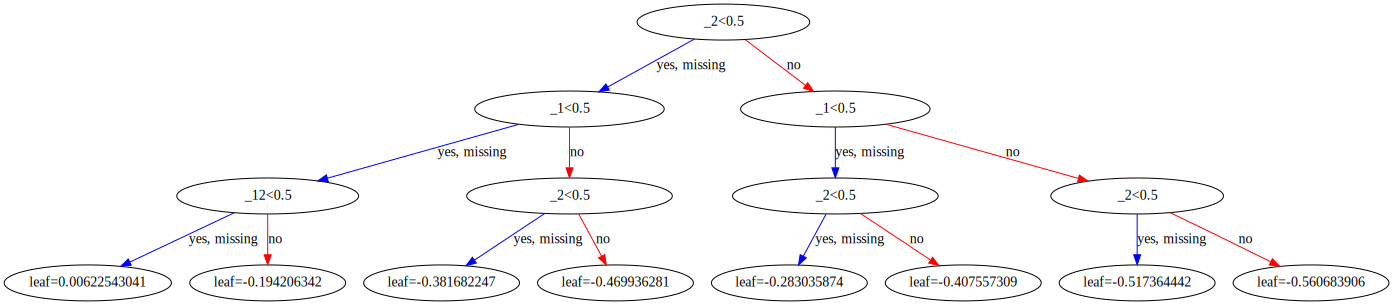

In [35]:
# 의사결정 트리 중 첫번째 트리 시각화
import xgboost as xgb
xgb.to_graphviz(booster = xgb_clf, num_trees=0)

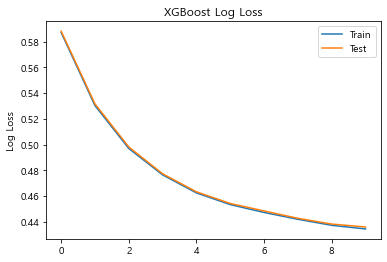

In [36]:
# 모델 성능 시각화

from matplotlib import pyplot
# retrieve performance metrics
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
#pyplot.show()
plt.savefig('XGBoost Log Loss.png')

# 4. 우범화물 예측 및 모델 성능 평가 <a id='id4'></a>

## 4.1. XGBoost 모델 예측

In [37]:
# evaluate xgboost model
print("------Evaluating xgboost model------")
# Predict
test_pred = xgb_clf.predict_proba(df_org_test)[:,1]
# Calculate auc
xgb_auc = roc_auc_score(org_test_y, test_pred)
print(xgb_auc)

------Evaluating xgboost model------
0.8102292739704993


## 4.2. 모델 예측 성능 평가

In [38]:
# 검사율에 따른 우범예측 함수 생성

def inspection_performance(predicted_fraud, test_fraud):
    
    # Set default values before a loop
    
    Inspect_Rate = []
    Precision=[]
    Recall=[]
    
    # Create a loop for making confusion matrix at each inspection rate

    for i in range(0,101,1):
        
        # Find the ith value in ascending order.
        threshold = np.percentile(predicted_fraud, i)
        # Precision = number of frauds / number of inspection
        precision = np.mean(test_fraud[predicted_fraud >= threshold])
        # Recall = number of inspected frauds / number of frauds
        recall = sum(test_fraud[predicted_fraud >= threshold])/sum(test_fraud)
        # Save values
        Inspect_Rate.append(100-i)
        Precision.append(precision)
        Recall.append(recall)
        
    
    compiled_conf_matrix = pd.DataFrame({
        
        'Inspect_Rate':Inspect_Rate,
        'Precision':Precision,
        'Recall':Recall
    })

    return compiled_conf_matrix

In [39]:
# 검사율에 따른 우범예측 
basic_performance = inspection_performance(test_pred, org_test_y.astype(float))

In [40]:
# 검사율 1~10% 지정 시 Precision 및 Recall 분석
# Precision (적중률) = (검사선별된 우범건수)/(검사선별 건수)
# Recall (적발률) = (검사선별된 우범건수) / (전체 우범건수)
basic_performance.iloc[range(99,89,-1),:]

,Inspect_Rate,Precision,Recall
99,1,0.677966,0.067039
98,2,0.677966,0.067039
97,3,0.678030,0.100000
96,4,0.659091,0.129609
95,5,0.648148,0.156425
94,6,0.631868,0.192737
93,7,0.631868,0.192737
92,8,0.618506,0.212849
91,9,0.619048,0.239665
90,10,0.614622,0.277095


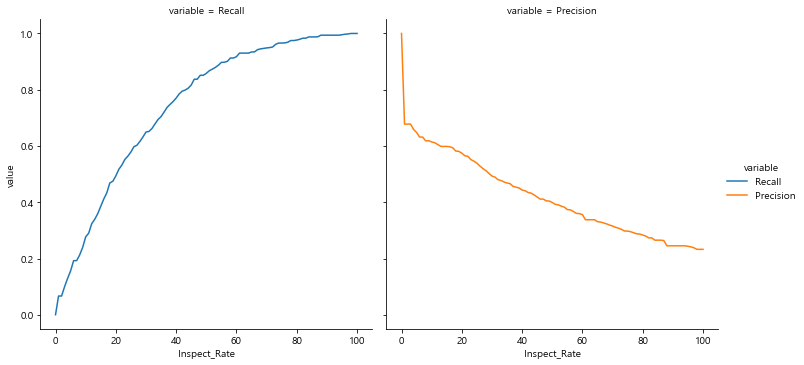

In [41]:
# 검사선별률에 따른 적중률 및 적발률 시각화
data = pd.melt(basic_performance, 
               id_vars = ['Inspect_Rate'],
               value_vars = ['Recall','Precision'])

sns.relplot(data=data,
            kind='line',
            x="Inspect_Rate", 
            y="value", 
            hue='variable',
            col="variable")
plt.savefig('recall & precision.png')


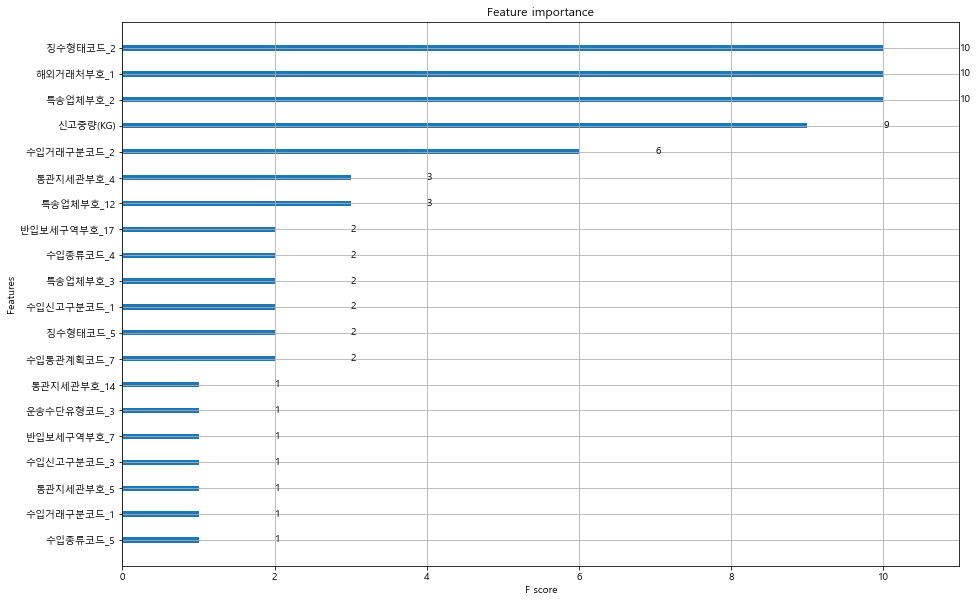

In [42]:
# 모델에 기여도가 높은 변수 시각화
from xgboost import plot_importance
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["figure.figsize"] = (15,10)
plot_importance(xgb_clf, max_num_features=30)
plt.show()

In [44]:
# 모델 종료 시간 확인
end = time.time()
# 모델 구동 시간 계산
print(f"모델구동시간 : {end-start} sec.")

모델구동시간 : 1330.3919486999512 sec.
